In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor, XGBClassifier

import shap

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt
import utils
import emb

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False
OVERWRITE = False


/Users/ekung/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = dt.get_post_quality_analysis_data()

df = df.loc[df['title'] != 'deleted by author'].reset_index(drop=True)

print(len(df))

/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time
/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time


175857


In [3]:
subs = df['subName'].unique().tolist()
sub_embeddings = {}
for sub in subs:
    embedding = np.array(emb.get_embedding_robust(sub))
    embedding = embedding / np.linalg.norm(embedding)
    sub_embeddings[sub] = embedding

In [4]:
title_embeddings = []
text_embeddings = []

for idx, row in df.iterrows():
    title_emb = np.array(emb.get_embedding_robust(row['title']))
    title_emb = title_emb / np.linalg.norm(title_emb)
    title_embeddings.append(title_emb)
    
    text_emb = np.array(emb.get_embedding_robust(row['text']))
    text_emb = text_emb / np.linalg.norm(text_emb)
    text_embeddings.append(text_emb)

title_embeddings = np.array(title_embeddings)
text_embeddings = np.array(text_embeddings)

In [5]:
#for idx, row in df.iterrows():
#    title = row['title']
#    text = row['text']
#    sub = row['subName']
#    
#    title_embedding = np.array(emb.get_embedding_robust(title))
#    title_embedding = title_embedding / np.linalg.norm(title_embedding)
#    
#    text_embedding = np.array(emb.get_embedding_robust(text))
#    text_embedding = text_embedding / np.linalg.norm(text_embedding)#
#
#    title_cos_dist = 1 - np.dot(title_embedding, sub_embeddings[sub])
#    text_cos_dist = 1 - np.dot(text_embedding, sub_embeddings[sub])
#
#    df.at[idx, 'title_cos_dist'] = title_cos_dist
#    df.at[idx, 'text_cos_dist'] = text_cos_dist

In [6]:
emb.close_connections()

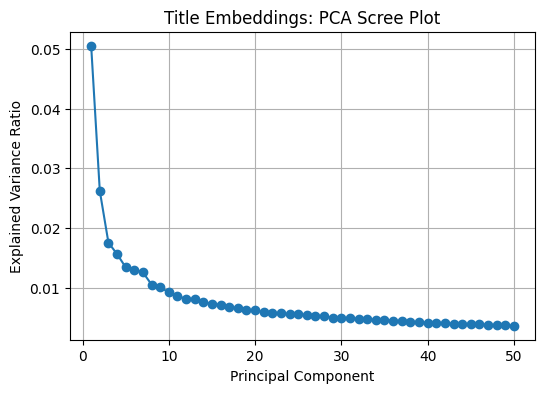

In [7]:
# scree plot for title embeddings
title_pca = PCA()
title_pca.fit(title_embeddings)
explained_variance = title_pca.explained_variance_ratio_[0:50]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Title Embeddings: PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
#filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
#plt.savefig(filename, bbox_inches='tight')
plt.show()



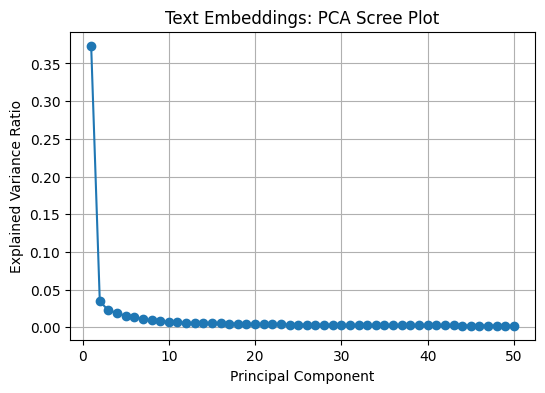

In [8]:
# scree plot for text embeddings
text_pca = PCA()
text_pca.fit(text_embeddings)
explained_variance = text_pca.explained_variance_ratio_[0:50]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Text Embeddings: PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
#filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
#plt.savefig(filename, bbox_inches='tight')
plt.show()



In [9]:
TITLE_PCA_K = 20

title_pca = PCA(n_components=TITLE_PCA_K)
title_pca.fit(title_embeddings)
title_pca_embeddings = title_pca.transform(title_embeddings)

for k in range(TITLE_PCA_K):
    df[f'title_emb_{k}'] = title_pca_embeddings[:, k]

TEXT_PCA_K = 20

text_pca = PCA(n_components=TEXT_PCA_K)
text_pca.fit(text_embeddings)
text_pca_embeddings = text_pca.transform(text_embeddings)

for k in range(TEXT_PCA_K):
    df[f'text_emb_{k}'] = text_pca_embeddings[:, k]

In [10]:
title_emb_cols = [f'title_emb_{k}' for k in range(TITLE_PCA_K)]
text_emb_cols = [f'text_emb_{k}' for k in range(TEXT_PCA_K)]
feature_cols = ['num_words', 'num_img_or_links', 'is_link_post'] + title_emb_cols + text_emb_cols

df['log_sats48'] = np.log1p(df['sats48'])

X = df[feature_cols]
Y = df['log_sats48']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=21
)

In [11]:
model.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

In [12]:
Y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = r2_score(Y, Y_pred)

print(f"XGB Model")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"N: {len(Y)}")

XGB Model
RMSE: 1.9011
R2: 0.3473
N: 175857


In [13]:
# OLS model for comparison

ols = LinearRegression(fit_intercept=True)
ols.fit(X, Y)
Y_pred_ols = ols.predict(X)
rmse_ols = np.sqrt(mean_squared_error(Y, Y_pred_ols))
r2_ols = r2_score(Y, Y_pred_ols)

print(f"OLS Model")
print(f"RMSE: {rmse_ols:.4f}")
print(f"R2: {r2_ols:.4f}")

OLS Model
RMSE: 2.1017
R2: 0.2023


In [14]:
feature_importance = pd.Series(
    model.feature_importances_, 
    index=model.feature_names_in_
).sort_values(ascending=False)

fi = feature_importance.rename('importance').reset_index()
fi['feature_group'] = fi['index']
fi.loc[ fi['index'].isin(title_emb_cols), 'feature_group' ] = 'title_embeddings'
fi.loc[ fi['index'].isin(text_emb_cols), 'feature_group' ] = 'text_embeddings'
fi = fi.groupby('feature_group').agg(
    importance = ('importance', 'sum')
).reset_index()

fi


,feature_group,importance
0,is_link_post,0.085101
1,num_img_or_links,0.040929
2,num_words,0.207344
3,text_embeddings,0.445644
4,title_embeddings,0.220982


In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

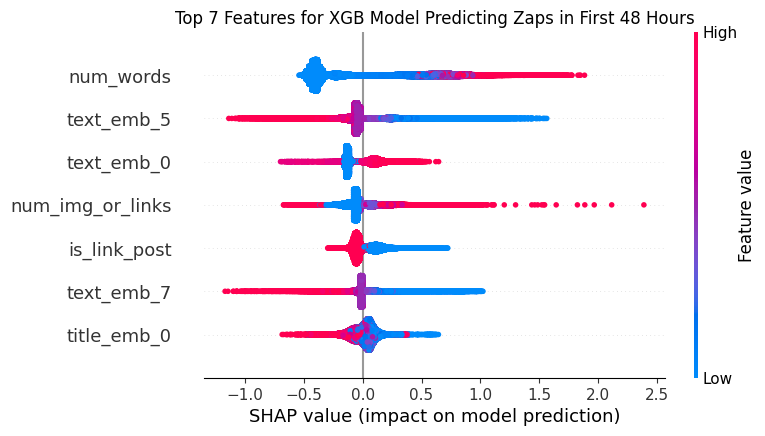

In [16]:
plt.figure(figsize=(6,4))
shap.summary_plot(shap_values, X, max_display=7, show=False)
plt.title("Top 7 Features for XGB Model Predicting Zaps in First 48 Hours")
plt.xlabel("SHAP value (impact on model prediction)")
plt.show()

In [17]:
print("Examples with high values of text_emb_5")
print("")

mydf = df.loc[ df['text_emb_5'] > np.quantile(df['text_emb_5'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_5

-------------
Title: Blackjack now available on Clinch!  (bitcoin gaming)
Territory: gaming
URL: None

Hey y’all. We just launched a new game: Blackjack. It is a skill-based version of the classic Blackjack where you compete head-to-head against an opponent. We’ve entirely eliminated the dealer (house), making the game more competitive and high stakes.

In THNDR Blackjack, you and your opponent face off with the exact same cards over 10 nail-biting rounds. Same deck, same dealer rules, same stakes. Only your moves decide who’s walking away with the pot. 

As always, the game uses our player liquidity network that always guarantees there is someone to play against. And payments across the liquidity network happen instantly on the Bitcoin Lightning Network.

Would love to have you guys try it out: https://www.clinch.gg/

Let us know what you think!


-------------
Title: Bank Abruptly Shut Down by US Regulators in Second Bank Failure of 2024
Terri

In [18]:
(df['sats48']>0).sum()

142501

In [19]:
print("Examples with low values of text_emb_5")
print("")

mydf = df.loc[ df['text_emb_5'] < np.quantile(df['text_emb_5'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_5

-------------
Title: Too late now, but bitcoiners should have held their own demonstrations today
Territory: bitcoin
URL: None

With military parades going on in Washington DC and counter-demonstrations full of communists going on everywhere else, this was an opportunity for Bitcoiners to show themselves as standing apart from the two shitty options society is offering us. We could've brought visibility to the fact that there's another option: an option for those who support private property and economic freedom while also standing against the tyranny of the state, and against wars and against the military industrial complex.

Oh well, this is just me armchair quarterbacking


-------------
Title: Why Are Recurring Dreams Usually Bad Ones?
Territory: science
URL: None

While reading today I stumbled accross an article that says [75% of people](https://karger.com/pps/article-abstract/59/3-4/203/329226/The-Impact-of-Dream-Interpretation-Using?redir

In [20]:
print("Examples with high values of text_emb_0")
print("")

mydf = df.loc[ df['text_emb_0'] > np.quantile(df['text_emb_0'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_0

-------------
Title: Core bitcoin hashes
Territory: bitcoin
URL: None

# Cheat sheet of the cryptographic hashes powering Bitcoin


![](https://m.stacker.news/107175)

---

## 1- Core Bitcoin Hashes

#### SHA-256
- Mining (Proof of Work): miners hash block headers  
- Transaction IDs (txid): each transaction gets a unique SHA-256 hash  
- Merkle tree construction (organizing transactions in blocks)  

#### SHA-256d (Double SHA-256)
- Block hashes (each block header hashed twice)  
- Extra security against length extension attacks  
- Checksums in addresses

#### RIPEMD-160
- Address generation: `RIPEMD160(SHA256(pubkey))`
- Shortens 256-bit SHA-256 into 160-bit hash  

#### HASH-160 (SHA-256 + RIPEMD-160)
- Used in P2PKH & P2SH addresses  

---

## 2- Wallet & Key Management Hashes

#### HMAC-SHA256 / SHA512
- Key derivation in BIP32 (HD wallets)  
- Secure key stretching  

### HKDF
- BIP-324 encrypted P2P transport
- Secure key expansion from 

In [21]:
print("Examples with low values of text_emb_0")
print("")

mydf = df.loc[ df['text_emb_0'] < np.quantile(df['text_emb_0'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_0

-------------
Title: Where to buy a Bitcoin Miner in 2023?
Territory: bitcoin
URL: https://hashrateindex.com/blog/where-to-buy-bitcoin-miner-in-2023



-------------
Title: 🖲️ Hey, it's Tech Tuesday!
Territory: agora
URL: None

Any enthusiasts today out there? Tell us about the latest gadgets, gizmos, or services you tried and share your experience with us.



-------------
Title: Node Runner: Top 5 Lightning Network Node Machines
Territory: bitcoin
URL: https://www.bitbyte.news/node-runner-top-5-lightning-network-node-machines/?ref=daily-byte-newsletter





In [22]:
print("Examples with high values of text_emb_7")
print("")

mydf = df.loc[ df['text_emb_7'] > np.quantile(df['text_emb_7'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with high values of text_emb_7

-------------
Title: @denlillaapan editor of “Bitcoin Girl: Save the World” at sunset with author RBD
Territory: booksandarticles
URL: None

![](https://m.stacker.news/109607)

@denlillaapan editor of “Bitcoin Girl: Save the World” at sunset with author @realBitcoinDog
https://youtube.com/shorts/VVPxVx6GBdg

https://a.co/d/hi1OOc5

-------------
Title: число
Territory: bitcoin
URL: None

назовите самое большое число? биткоин назовет еще больше.. сколько может быть блоков в блок чейне? назовите самый долгий промежуток времени? биткоин покажет еще дольше...

Пипец квантовая теория не способна изминить что то в ближаийше 1000000 лет


-------------
Title: How you could soon buy Hobbs House Bakery buns with Bitcoin
Territory: food_and_drinks
URL: https://www.soglos.com/news/business/how-you-could-soon-buy-hobbs-house-bakery-buns-with-bitcoin/24459/

This is a few months old now, but I didn't see it circulating at the time.

> One of [Bitcoin's] fans

In [23]:
print("Examples with low values of text_emb_7")
print("")

mydf = df.loc[ df['text_emb_7'] < np.quantile(df['text_emb_7'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')
    print(row['text'])
    print('')

Examples with low values of text_emb_7

-------------
Title: Getting ready Saturday
Territory: bitcoin
URL: None

The Atlanta team have been refining and prioritizing the Abbot backlog. Putting our ideas in order, onboarding new team members and getting hands on the code. We got our MVP ready and moving!!!! Fun and Productive Saturday!!!!

-------------
Title: Top five podcasts
Territory: bitcoin
URL: None

Be interested to see the communities top 5 podcasts? So many podcasts these days good to find the best ones that I may have missed 

-------------
Title: POLL: What is your main reason for not paying with bitcoin?
Territory: bitcoin
URL: None

We had a [discussion recently here at SN on this topic](https://stacker.news/items/210830) and it was awesome. 🚀

Thank you for your participation. I’ve collected the answers and now I would like to add numbers to it. Can you share your sat to this poll to help me understand better `What is your main reason for not paying with bitcoin`?



In [24]:
print("Examples with high values of title_emb_1")
print("")

mydf = df.loc[ df['title_emb_1'] > np.quantile(df['title_emb_1'], 0.9) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')


Examples with high values of title_emb_1

-------------
Title: Live: The Lightsats dev team talking about lightning on web 
Territory: bitcoin
URL: None

-------------
Title: Nostpy Relay v0.8 Released
Territory: nostr
URL: None

-------------
Title: New Techniques: Uncovering Tor Hidden Service with Etag
Territory: tech
URL: https://sh1ttykids.medium.com/new-techniques-uncovering-tor-hidden-service-with-etag-5249044a0e9d



In [25]:
print("Examples with low values of title_emb_1")
print("")

mydf = df.loc[ df['title_emb_1'] < np.quantile(df['title_emb_1'], 0.1) ].reset_index(drop=True)

for idx, row in mydf.sample(3).iterrows():
    print(f"-------------")
    print(f"Title: {row['title']}")
    print(f"Territory: {row['subName']}")
    print(f"URL: {row['url']}")
    print('')


Examples with low values of title_emb_1

-------------
Title: US annual CPI inflation
Territory: agora
URL: None

-------------
Title: Scandal deepens around CNN’s Clarissa Ward staging Syria prison scene
Territory: conspiracy
URL: https://thegrayzone.com/2024/12/16/scandal-cnns-clarissa-ward-staging-syria-prison/

-------------
Title: How Sweden’s stock market became the envy of Europe
Territory: econ
URL: https://www.ft.com/content/edc1bba0-25ca-4148-96f6-d67e30f11a2e



In [26]:
print(f"Diamonds in the rough")
print("")

df['log_sats48_pred'] = Y_pred
df['residual'] = df['log_sats48'] - df['log_sats48_pred']

mydf = df.sort_values(by='residual', ascending=True).head(5).reset_index(drop=True)

print("| Item | Title | Territory |")
print("| ---- | ----- | --------- |")
for idx, row in mydf.iterrows():
    print("| ", end='')
    print(f"https://stacker.news/items/{row['itemId']} | ", end='')
    print(f"{row['title']} | ", end='')
    print(f"{row['subName']} |")


Diamonds in the rough

| Item | Title | Territory |
| ---- | ----- | --------- |
| https://stacker.news/items/220897 | Bitcoin Tells an Unchanging Story | bitcoin |
| https://stacker.news/items/132056 | Tutanota, A Protonmail Alternative? | bitcoin |
| https://stacker.news/items/1240569 | Nunchuk (I): Fundamentals and Security Mindset | diy |
| https://stacker.news/items/990187 | Use of OP_RETURN in coinjoin transactions | bitdevs |
| https://stacker.news/items/30127 | "Crypto currencies are not currencies. They are not. They are not. They are not." -Christine Lagarde President of the European Central Bank | bitcoin |


In [27]:
# Output for regression in R
df_out = df.drop(columns=text_emb_cols + title_emb_cols)
out_filename = os.path.join(DATA_PATH, 'objective_quality_analysis.parquet')
df_out.to_parquet(out_filename, index=False)